# Hypnogram Extraction Using YASA
### YASA 모델을 이용하여, prepared subject에 대한 hypnogram을 얻는다

In [1]:
# import modules
import os
import numpy as np
from tqdm.notebook import tqdm, trange
import pandas as pd
import matplotlib.pyplot as plt
import mne
import yasa
import datetime

import choose_subjects

## 1. Prepared Subjects
- condition 1: a subject who has a ground-truth-hypnogram
- condition 2: a subject who has a edf file

In [6]:
# data path 선언
ground_truth_path = 'D:\\USC\\Sleep dataset\\Samsung_data\\GROUND_TRUTH_STAGING'
edf_path = 'D:\\USC\\Sleep dataset\\Samsung_data\\REGULAR_EDF'

# get prepared_subjects using 'choose_subjects' module
prepared_subjects = choose_subjects.choose_prepared_edf(ground_truth_path, edf_path)
print(prepared_subjects)
print("\n-- Number of prepared subjects: {}".format(len(prepared_subjects)))

# select a subject we want to analyze
now_subject_num = 7

now_edf = os.path.join(edf_path, prepared_subjects[now_subject_num]) + '\\Traces.edf'
print("Now edf: {}".format(now_edf))

['LE004 박규희', 'LE010 신지윤', 'LE011 서영진', 'LE014 황지은', 'LE019 황주민', 'LE020 김세영', 'LE021 이지영', 'LE023 이해림']

-- Number of prepared subjects: 8
Now edf: D:\USC\Sleep dataset\Samsung_data\REGULAR_EDF\LE023 이해림\Traces.edf


# 2. Load edf files 
- using mne module

In [7]:
raw = mne.io.read_raw_edf(now_edf, preload=True)
raw

Extracting EDF parameters from D:\USC\Sleep dataset\Samsung_data\REGULAR_EDF\LE023 이해림\Traces.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10552999  =      0.000 ... 21105.998 secs...


C:\Users\CYS\AppData\Local\Temp/ipykernel_7648/2265627687.py:1: RuntimeWarning: Channel names are not unique, found duplicates for: {'LOC', 'ROC', 'SO'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(now_edf, preload=True)
C:\Users\CYS\AppData\Local\Temp/ipykernel_7648/2265627687.py:1: RuntimeWarning: Scaling factor is not defined in following channels:
Flattening, Pleth Amplitude, Chin, L-Leg, EKG, R-Leg, SO-0, SO-1, LOC-0, LOC-1, ROC-0, ROC-1, A1, C3, C3-A2, C4, C4-A1, A2, O1, O1-A2, O2, O2-A1, IO, Down-A2, F3, F3-A2, F4, F4-A1, Light_BU, Nasal Pressure, Thermistor, Snoring Sensor, Thorax, Abdomen, Gravity X, Gravity Y, Plethysmogram, Pulse, RD-Quality, SpO2, SpO2 BB, Heart Rate_DR, SpO2-Quality_DR, Flow_DR, Snore_DR, Activity_DR, Elevation_DR, Position_DR, Phase_DR, RMI_DR, RR_DR, XSum_DR, Tidal Volume_DR, XFlow_DR
  raw = mne.io.read_raw_edf(now_edf, preload=True)


<RawEDF | Traces.edf, 54 x 10553000 (21106.0 s), ~4.25 GB, data loaded>

In [8]:
# remove the EOG, EMG, and EKG channels
# raw.drop_channels(['ROC-A1', 'LOC-A2', 'EMG1-EMG2', 'EKG-R-EKG-L'])
print("-- Total Channels: {}".format(raw.ch_names))
eog = ['no_eog', '', 'SO', 'SO-0', 'SO-1', 'IO']
if '박규희' in now_edf:
    eeg = ['C3', 'C4']
else:
    eeg = ['C3-A2', 'C4-A1']
raw.pick_channels(eeg + eog)
chan = raw.ch_names
print("-- Available Channels: {}".format(chan))

-- Total Channels: ['Flattening', 'Pleth Amplitude', 'Chin', 'L-Leg', 'EKG', 'R-Leg', 'SO-0', 'SO-1', 'LOC-0', 'LOC-1', 'ROC-0', 'ROC-1', 'A1', 'C3', 'C3-A2', 'C4', 'C4-A1', 'A2', 'O1', 'O1-A2', 'O2', 'O2-A1', 'IO', 'Down-A2', 'F3', 'F3-A2', 'F4', 'F4-A1', 'Light_BU', 'Nasal Pressure', 'Thermistor', 'Snoring Sensor', 'Thorax', 'Abdomen', 'Gravity X', 'Gravity Y', 'Plethysmogram', 'Pulse', 'RD-Quality', 'SpO2', 'SpO2 BB', 'Heart Rate_DR', 'SpO2-Quality_DR', 'Flow_DR', 'Snore_DR', 'Activity_DR', 'Elevation_DR', 'Position_DR', 'Phase_DR', 'RMI_DR', 'RR_DR', 'XSum_DR', 'Tidal Volume_DR', 'XFlow_DR']
-- Available Channels: ['SO-0', 'SO-1', 'C3-A2', 'C4-A1', 'IO']


In [9]:
# data cropping
# ground_truth_hypnogram과 edf 데이터의 시간이 다르므로, 이것을 match 시켜 준다

# -- 1. load event.txt and get start and end time of ground-truth-labeling
print("Read EDF of {}".format(prepared_subjects[now_subject_num]))

ground_events_path = 'D:\\USC\\Sleep dataset\\Samsung_data\\GROUND_TRUTH_STAGING'
events = os.listdir(ground_events_path)
# print(events)
choose_idx = []
i = 0
for event in events:
    if prepared_subjects[now_subject_num][0:5] in event:
        choose_idx.append(i)
    i += 1
print("\n -- Now subject is: {}".format(events[choose_idx[0]]))

f = open(os.path.join(ground_events_path, events[choose_idx[0]]), 'r')
lines = f.readlines()
print(lines[17].strip().split())
print(lines[18].strip().split())
print(lines[len(lines)-1].strip().split())
f.close

hypno_start = lines[18].strip().split()[1]
hypno_start_sec = int(hypno_start[0:2])*3600 + int(hypno_start[3:5])*60 + int(hypno_start[6:8])
hypno_end = lines[len(lines)-1].strip().split()[1]
hypno_end_sec = int(hypno_end[0:2])*3600 + int(hypno_end[3:5])*60 + int(hypno_end[6:8])

print("\nhypno_start: {} ({} seconds)".format(hypno_start, hypno_start_sec))
print("hypno_end: {} ({} seconds)".format(hypno_end, hypno_end_sec))

# -- 2. get edf_start 
edf_start_hour = raw.info['meas_date'].hour
edf_start_min = raw.info['meas_date'].minute
edf_start_sec = raw.info['meas_date'].second

edf_start = (lambda x: '0'+x if len(x) < 8 else x)(str(edf_start_hour) + ':' + str(edf_start_min) + ':' + str(edf_start_sec))
edf_start_sec = edf_start_hour*3600+edf_start_min*60+edf_start_sec

print("\nedf_start: {} ({} seconds)".format(edf_start, edf_start_sec))

edf_duration = raw.times[-1:]
edf_end_sec = int(edf_start_sec + edf_duration)
edf_end = (lambda x: '0'+x if len(x) < 8 else x)(str(datetime.timedelta(seconds=int(np.floor(edf_end_sec)))))
print("edf_end: {} ({} seconds)".format(edf_end, edf_end_sec))

# hour = np.floor(k/60/60)
# minute = np.floor((k-hour*3600)/60)
# second = np.floor(k-hour*3600-minute*60)
# print(k)
# print(hour)
# print(minute)
# print(second)


# -- 3. cut the edf data to match with the hypnogram
# tmin = hypno_start_sec - edf_start_sec -30
# tmax = hypno_end_sec - edf_start_sec
# raw.crop(tmin=tmin, tmax=tmax)

Read EDF of LE023 이해림

 -- Now subject is: LE023-Events.txt
['Sleep', 'Stage', 'Time', '[hh:mm:ss]', 'Event', 'Duration[s]']
['SLEEP-S0', '00:33:30', 'SLEEP-S0', '30']
['SLEEP-S0', '05:45:00', 'SLEEP-S0', '30']

hypno_start: 00:33:30 (2010 seconds)
hypno_end: 05:45:00 (20700 seconds)

edf_start: 00:21:53 (1313 seconds)
edf_end: 06:13:38 (22418 seconds)


In [6]:
# Downsampling and filtering
print("-- Original sampling rate: {}".format(raw.info['sfreq']))
raw.resample(100)
print("-- Sampling rate after downsampled: {}\n".format(raw.info['sfreq']))

# 0.3-45 Hz bandpass-filter
raw.filter(0.3, 45)

# get single EEG data
data = raw.get_data() * 1e6
print("Shape of single EEG data: {}".format(data.shape))

-- Original sampling rate: 500.0
-- Sampling rate after downsampled: 100.0

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 47.50 Hz)
- Filter length: 1101 samples (11.010 sec)

Shape of single EEG data: (1, 1929000)


In [7]:
# data = raw.get_data()
# print("Shape before cutting: {}".format(data.shape))
# print("Epochs before cutting: {}".format(data.shape[1]/500/30))

# start_gap = 12*60+51 # start gap in seconds
# end_gap = -44*60+24 # end gap in seconds

# data_cut = data[:, start_gap*500:end_gap*500]
# print("Shape after cutting: {}".format(data_cut.shape))
# print("Epochs before cutting: {}".format(data_cut.shape[1]/500/30))

# 3. Automatic Sleep Staging

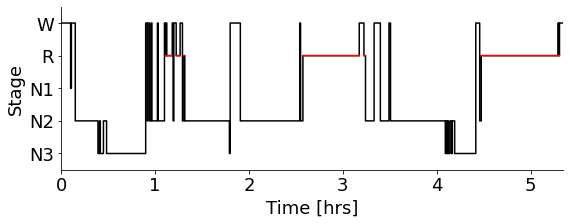

In [8]:
sls = yasa.SleepStaging(raw, eeg_name=eeg)#, eog_name = eog)
hypno_pred = sls.predict()  # Predict the sleep stages
hypno_pred = yasa.hypno_str_to_int(hypno_pred)  # Convert "W" to 0, "N1" to 1, etc
yasa.plot_hypnogram(hypno_pred);  # Plot

In [9]:
# convert hypnogram into pd.DataFrame and Save as csv
df_hypno = pd.DataFrame(hypno_pred, columns=['stages'])
path_save = os.path.join('D:\\USC\\code_mine\\yasa_examination\\predicted_hypnogram', prepared_subjects[now_subject_num][0:5]) + '.csv'
print("Save as: {}".format(path_save))
df_hypno.to_csv(path_or_buf=path_save, index=None)

Save as: D:\USC\code_mine\yasa_examination\predicted_hypnogram\LE004.csv


# 4. Load Ground-Truth-Hypnograms-In-Numbers

In [10]:
path_InNum_Hypnos = 'D:\\USC\\test_data\\Prepared_InNum_Hypnos'
InNum_Hypnos = os.listdir(path_InNum_Hypnos)
print("-- Total prepared hypnograms: {}".format(os.listdir(path_InNum_Hypnos)))
print("\n-- Available hypnogram: {}".format(InNum_Hypnos[now_subject_num]))

ground_truth_hypno = pd.read_csv(os.path.join(path_InNum_Hypnos, InNum_Hypnos[now_subject_num]), squeeze=True)
ground_truth_hypno

-- Total prepared hypnograms: ['LE004.csv', 'LE010.csv', 'LE011.csv', 'LE014.csv', 'LE019.csv', 'LE020.csv', 'LE021.csv', 'LE022.csv', 'LE023.csv']

-- Available hypnogram: LE004.csv


C:\Users\CYS\AppData\Local\Temp\ipykernel_7584\3961499472.py:6: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  ground_truth_hypno = pd.read_csv(os.path.join(path_InNum_Hypnos, InNum_Hypnos[now_subject_num]), squeeze=True)


0      0
1      0
2      0
3      0
4      0
      ..
638    0
639    0
640    0
641    0
642    0
Name: stages, Length: 643, dtype: int64

<AxesSubplot:xlabel='Time [hrs]', ylabel='Stage'>

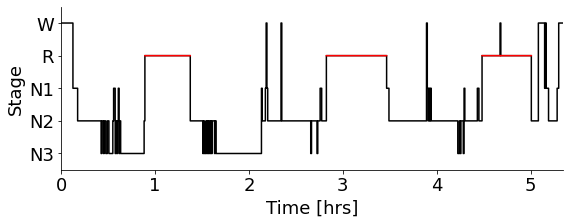

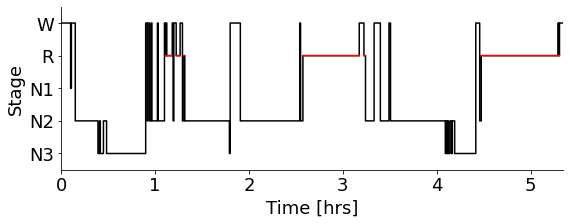

In [11]:
yasa.plot_hypnogram(ground_truth_hypno)
yasa.plot_hypnogram(hypno_pred)

In [12]:
# yasa.plot_hypnogram(ground_truth_hypno)
# yasa.plot_hypnogram(hypno_pred[0:643])

In [13]:
print("Length of ground_truth: {}".format(len(ground_truth_hypno)))
print("Length of predicted: {}".format(len(hypno_pred)))
path = 'D:\\USC\\code_mine\\yasa_examination\\predicted_hypnogram\\' + prepared_subjects[now_subject_num][0:5] + '.txt'
f = open(path, 'wt')
f.writelines(['ground_truth' + '  ' + 'predicted\n'])
f.writelines([str(len(ground_truth_hypno)) + '  ' + str(len(hypno_pred))])
f.close()

Length of ground_truth: 643
Length of predicted: 643


In [14]:
from sklearn.metrics import accuracy_score
# print(f"The accuracy is {100 * accuracy_score(ground_truth_hypno, hypno_pred[0:643]):.3f}%")
print(f"The accuracy is {100 * accuracy_score(ground_truth_hypno, hypno_pred):.3f}%")

The accuracy is 56.143%


In [6]:
hypno_start_sec = 1470
hypno_end_sec = 23790
edf_start_sec = 919
edf_end_sec = 23288
if (hypno_start_sec < edf_start_sec) | (hypno_end_sec > edf_end_sec):
    print("wow")
else:
    print("no")

wow


In [3]:
(hypno_end_sec > edf_end_sec)

True

Text(0.5, 1.0, 'wow')

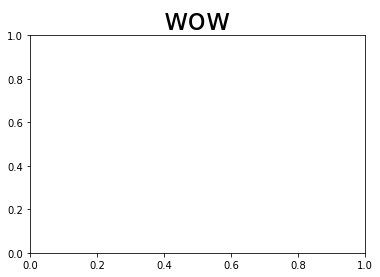

In [5]:
import matplotlib.pyplot as plt
plt.title('wow', fontsize=30)